## XGBoost Match Outcome Prediction

### Inputs
- All numeric features from dataset (team statistics, goals, positions, etc.)
- homeTeam_name (one-hot encoded)
- awayTeam_name (one-hot encoded)

### Target
- 0.0 = Tie (draw)
- 1.0 = Away team won
- 2.0 = Home team won


In [89]:
%pip install pandas numpy scikit-learn matplotlib seaborn xgboost



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: /home/alex/.venvs/py39/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [90]:
from __future__ import annotations

import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
)
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

# Env settings for matplotlib
os.environ.setdefault("MPLCONFIGDIR", str(Path.cwd() / ".mplconfig"))
Path(os.environ["MPLCONFIGDIR"]).mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 120


## 2) Load the dataset

- Load all available features from ml_dataset.csv
- Clean team names and matchday
- Prepare for feature engineering


In [91]:
df_raw = pd.read_csv('../cleared_data/ml_dataset.csv')

# Basic cleanup
df = df_raw.copy()

# Clean team names
for c in ["homeTeam_name", "awayTeam_name"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

# Drop rows with missing target
df = df.dropna(subset=["match_outcome"]).copy()
df["match_outcome"] = df["match_outcome"].astype(int)

# Ensure matchday is integer
if "matchday" in df.columns:
    df = df.dropna(subset=["matchday"]).copy()
    df["matchday"] = df["matchday"].astype(int)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
df.head()


Dataset shape: (1140, 86)
Columns: 86


,awayTeam_name,competition_name,homeTeam_name,matchday,score_fullTime_away,score_fullTime_home,score_halfTime_away,score_halfTime_home,match_outcome,home_points,...,goals_against_diff,points_diff,position_diff,home_advantage_metric,top_scorer_goals_diff,top3_goals_diff,scoring_depth_diff,num_scorers_diff,total_goals,goal_margin
0,Rayo Vallecano de Madrid,Primera Division,UD Almería,1,2.0,0.0,2.0,0.0,0,21,...,27,-31,-10,-13,3.0,4.0,-2.0,-1.0,2.0,-2.0
1,Valencia CF,Primera Division,Sevilla FC,1,2.0,1.0,0.0,0.0,0,41,...,1,-8,-4,8,3.0,-2.0,-24.0,-4.0,3.0,-1.0
2,Girona FC,Primera Division,Real Sociedad de Fútbol,1,1.0,1.0,0.0,1.0,1,60,...,-14,-21,-3,3,-15.0,-19.0,-19.0,-1.0,2.0,0.0
3,RCD Mallorca,Primera Division,UD Las Palmas,1,1.0,1.0,0.0,1.0,1,40,...,17,-8,-6,1,0.0,1.0,-6.0,-1.0,2.0,0.0
4,Real Madrid CF,Primera Division,Athletic Club,1,2.0,0.0,2.0,0.0,0,70,...,-1,-25,-3,-1,-16.0,-27.0,-61.0,-4.0,2.0,-2.0


## 3) Feature Engineering

- Separate numeric and categorical features
- Identify all available features from the dataset
- Map outcome labels


In [92]:
OUTCOME_LABELS = {0: "Tie", 1: "Away Won", 2: "Home Won"}

# Sanity check
unexpected = sorted(set(df["match_outcome"]) - set(OUTCOME_LABELS))
if unexpected:
    raise ValueError(f"Unexpected match_outcome values: {unexpected}")

df["outcome_label"] = df["match_outcome"].map(OUTCOME_LABELS)

# Exclude data leakage features (scores that directly reveal the outcome)
# These features cause perfect predictions because they contain the answer!
leakage_features = [
    "match_outcome", "outcome_label",  # Target variable
    "score_fullTime_home", "score_fullTime_away",  # Actual match scores
    "score_halfTime_home", "score_halfTime_away",  # Half-time scores
    "total_goals", "goal_margin",  # Derived from scores
]

# Use all other features from dataset (no transformations)
feature_cols = [col for col in df.columns if col not in leakage_features]

# Separate categorical and numeric features
categorical_cols = []
numeric_cols = []

for col in feature_cols:
    if df[col].dtype == 'object':
        categorical_cols.append(col)
    elif df[col].dtype in ['int64', 'float64']:
        numeric_cols.append(col)

print(f"Excluded leakage features: {leakage_features}")
print(f"\nTotal features: {len(feature_cols)}")
print(f"Categorical features: {len(categorical_cols)}")
print(f"Numeric features: {len(numeric_cols)}")
print(f"\nCategorical features: {categorical_cols}")
print(f"\nNumeric features (first 10): {numeric_cols[:10]}...")


Excluded leakage features: ['match_outcome', 'outcome_label', 'score_fullTime_home', 'score_fullTime_away', 'score_halfTime_home', 'score_halfTime_away', 'total_goals', 'goal_margin']

Total features: 79
Categorical features: 3
Numeric features: 76

Categorical features: ['awayTeam_name', 'competition_name', 'homeTeam_name']

Numeric features (first 10): ['matchday', 'home_points', 'home_won', 'home_draw', 'home_lost', 'home_goalsFor', 'home_goalsAgainst', 'home_goalDifference', 'home_position', 'home_team_id_match']...


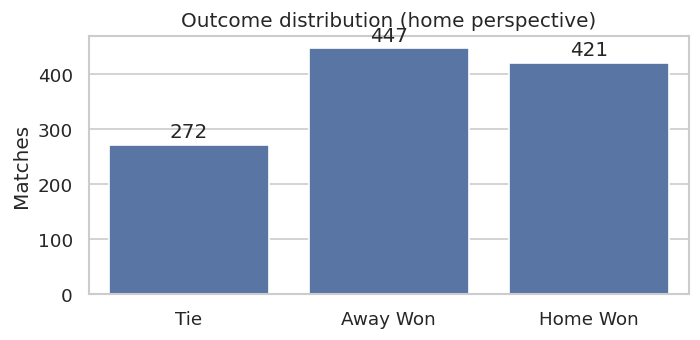


Class distribution:
outcome_label
Away Won    447
Home Won    421
Tie         272
Name: count, dtype: int64

Class percentages:
outcome_label
Away Won    0.392
Home Won    0.369
Tie         0.239
Name: proportion, dtype: float64


In [93]:
# Visualize outcome distribution
order = ["Tie", "Away Won", "Home Won"]

plt.figure(figsize=(6, 3))
ax = sns.countplot(data=df, x="outcome_label", order=order)
ax.set_title("Outcome distribution (home perspective)")
ax.set_xlabel("")
ax.set_ylabel("Matches")
for container in ax.containers:
    ax.bar_label(container, padding=2)
plt.tight_layout()
plt.show()

# Check class distribution
print("\nClass distribution:")
print(df["outcome_label"].value_counts())
print("\nClass percentages:")
print(df["outcome_label"].value_counts(normalize=True).round(3))


## 4) Train/test split (80%/20%)

- Use sklearn's train_test_split with stratification
- Prepare feature matrices


In [94]:
# Prepare X and y
X = df[feature_cols].copy()
y = df["match_outcome"]

# Train/test split using sklearn (like simple_feature_model)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=RANDOM_STATE, stratify=y
)

print("Train/Test Split Summary:")
print(f"  Total matches: {len(df)}")
print(f"  Train matches: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"  Test matches: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")
print(f"  Total features: {len(feature_cols)}")
print(f"  Numeric features: {len(numeric_cols)}")
print(f"  Categorical features: {len(categorical_cols)}")
print(f"\nTrain class distribution:")
print(y_train.value_counts().sort_index())
print(f"\nTest class distribution:")
print(y_test.value_counts().sort_index())


Train/Test Split Summary:
  Total matches: 1140
  Train matches: 912 (80.0%)
  Test matches: 228 (20.0%)
  Total features: 79
  Numeric features: 76
  Categorical features: 3

Train class distribution:
match_outcome
0    217
1    358
2    337
Name: count, dtype: int64

Test class distribution:
match_outcome
0    55
1    89
2    84
Name: count, dtype: int64


## 5) Model pipeline with sklearn

- Use ColumnTransformer to preprocess features
- One-hot encode team names
- Impute missing values for numeric features
- Train XGBoost classifier


In [95]:
# Create preprocessing pipeline using sklearn ColumnTransformer
# No imputation, no scaling - use data as-is (like simple_feature_model)
preprocess = ColumnTransformer(
    transformers=[
        (
            "categorical",
            OneHotEncoder(handle_unknown="ignore"),
            categorical_cols,
        ),
        (
            "numeric",
            "passthrough",  # Pass numeric features through without transformation
            numeric_cols,
        ),
    ],
    remainder="drop",
)

# Base XGBoost model
base_model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    random_state=RANDOM_STATE,
    verbosity=0,
)

# Full pipeline
pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", base_model),
    ]
)

pipeline


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['awayTeam_name',
                                                   'competition_name',
                                                   'homeTeam_name']),
                                                 ('numeric', 'passthrough',
                                                  ['matchday', 'home_points',
                                                   'home_won', 'home_draw',
                                                   'home_lost', 'home_goalsFor',
                                                   'home_goalsAgainst',
                                                   'home_goalDifference',
                                                   'home_position',
                                                   'home_team_id_match'...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, num_class=3,
                               num_parallel_tree=None, ...))])

## 6) Cross-validation

- Use StratifiedKFold for cross-validation (like simple_feature_model)
- Ensures balanced class distribution in each fold


In [96]:
# Use StratifiedKFold for cross-validation (like simple_feature_model)
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)


## 7) Hyperparameter tuning

- Use sklearn's cross_validate with time-aware CV splits
- Tune key hyperparameters: max_depth, learning_rate, n_estimators
- Optimize for macro F1 score


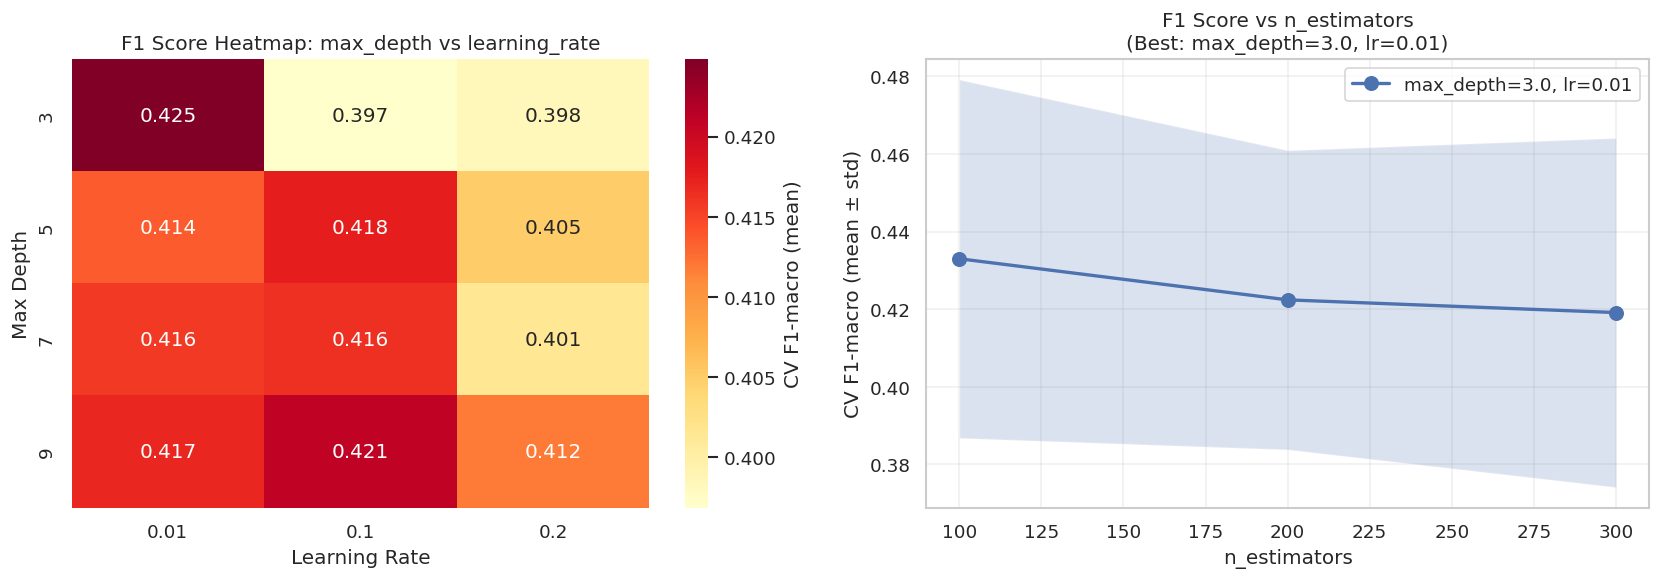


Top 10 hyperparameter configurations:
 max_depth  learning_rate  n_estimators  cv_f1_macro_mean  cv_f1_macro_std
         3           0.01           100          0.432982         0.046175
         9           0.10           200          0.425143         0.037724
         7           0.01           300          0.422525         0.028784
         3           0.01           200          0.422384         0.038549
         7           0.10           100          0.422377         0.040161
         9           0.01           100          0.421557         0.031046
         9           0.10           300          0.420453         0.033222
         5           0.10           300          0.419267         0.034568
         3           0.01           300          0.419113         0.044989
         7           0.10           200          0.418328         0.044925


In [97]:
# Visualize hyperparameter tuning results
# Plot F1 scores across different hyperparameter combinations

# Create a pivot table for heatmap visualization
# Group by max_depth and learning_rate, showing mean F1 score
pivot_f1 = tuning_df.pivot_table(
    values='cv_f1_macro_mean',
    index='max_depth',
    columns='learning_rate',
    aggfunc='mean'
)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap of F1 scores by max_depth and learning_rate
sns.heatmap(
    pivot_f1,
    annot=True,
    fmt='.3f',
    cmap='YlOrRd',
    ax=axes[0],
    cbar_kws={'label': 'CV F1-macro (mean)'}
)
axes[0].set_title('F1 Score Heatmap: max_depth vs learning_rate')
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Max Depth')

# Line plot showing F1 vs n_estimators for best max_depth and learning_rate
best_combo = tuning_df.loc[tuning_df['cv_f1_macro_mean'].idxmax()]
best_max_depth = best_combo['max_depth']
best_lr = best_combo['learning_rate']

best_subset = tuning_df[
    (tuning_df['max_depth'] == best_max_depth) & 
    (tuning_df['learning_rate'] == best_lr)
].sort_values('n_estimators')

axes[1].plot(
    best_subset['n_estimators'],
    best_subset['cv_f1_macro_mean'],
    marker='o',
    linewidth=2,
    markersize=8,
    label=f'max_depth={best_max_depth}, lr={best_lr}'
)
axes[1].fill_between(
    best_subset['n_estimators'],
    best_subset['cv_f1_macro_mean'] - best_subset['cv_f1_macro_std'],
    best_subset['cv_f1_macro_mean'] + best_subset['cv_f1_macro_std'],
    alpha=0.2
)
axes[1].set_xlabel('n_estimators')
axes[1].set_ylabel('CV F1-macro (mean ± std)')
axes[1].set_title(f'F1 Score vs n_estimators\n(Best: max_depth={best_max_depth}, lr={best_lr})')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Show top 10 configurations
print("\nTop 10 hyperparameter configurations:")
print(tuning_df[['max_depth', 'learning_rate', 'n_estimators', 'cv_f1_macro_mean', 'cv_f1_macro_std']].head(10).to_string(index=False))


In [98]:
# Hyperparameter tuning using sklearn cross_validate
max_depths = [3, 5, 7, 9]
learning_rates = [0.01, 0.1, 0.2]
n_estimators_list = [100, 200, 300]

rows = []
for max_depth in max_depths:
    for learning_rate in learning_rates:
        for n_estimators in n_estimators_list:
            model = xgb.XGBClassifier(
                objective="multi:softprob",
                num_class=3,
                eval_metric="mlogloss",
                max_depth=max_depth,
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                random_state=RANDOM_STATE,
                verbosity=0,
            )
            pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])

            scores = cross_validate(
                pipe,
                X_train,
                y_train,
                cv=cv,
                scoring={"acc": "accuracy", "f1_macro": "f1_macro"},
                n_jobs=-1,
                error_score="raise",
            )

            rows.append(
                {
                    "max_depth": max_depth,
                    "learning_rate": learning_rate,
                    "n_estimators": n_estimators,
                    "cv_acc_mean": float(np.mean(scores["test_acc"])),
                    "cv_acc_std": float(np.std(scores["test_acc"])),
                    "cv_f1_macro_mean": float(np.mean(scores["test_f1_macro"])),
                    "cv_f1_macro_std": float(np.std(scores["test_f1_macro"])),
                }
            )

tuning_df = pd.DataFrame(rows).sort_values("cv_f1_macro_mean", ascending=False)
tuning_df.head(10)


,max_depth,learning_rate,n_estimators,cv_acc_mean,cv_acc_std,cv_f1_macro_mean,cv_f1_macro_std
0,3,0.01,100,0.549324,0.020725,0.525265,0.023741
1,3,0.01,200,0.541668,0.020018,0.518438,0.017059
2,3,0.01,300,0.531802,0.013931,0.508243,0.011231
9,5,0.01,100,0.528487,0.029952,0.503220,0.030015
10,5,0.01,200,0.521930,0.025486,0.500488,0.020031
11,5,0.01,300,0.515367,0.024270,0.492731,0.021378
19,7,0.01,200,0.507704,0.034136,0.484796,0.030087
18,7,0.01,100,0.505489,0.039602,0.478929,0.039792
3,3,0.10,100,0.497802,0.022712,0.475457,0.019875
20,7,0.01,300,0.494542,0.027522,0.474152,0.023084


## 8) Select best parameters and train final model

- Select best hyperparameters from tuning
- Train final model with all training data


In [99]:
best_row = tuning_df.iloc[0].to_dict()
best_max_depth = int(best_row["max_depth"])
best_learning_rate = float(best_row["learning_rate"])
best_n_estimators = int(best_row["n_estimators"])

print(f"Best parameters:")
print(f"  max_depth: {best_max_depth}")
print(f"  learning_rate: {best_learning_rate}")
print(f"  n_estimators: {best_n_estimators}")
print(f"  CV F1-macro: {best_row['cv_f1_macro_mean']:.4f} ± {best_row['cv_f1_macro_std']:.4f}")

# Train final model with best parameters
final_model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    max_depth=best_max_depth,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    random_state=RANDOM_STATE,
    verbosity=1,
)

final_pipeline = Pipeline(steps=[("preprocess", preprocess), ("model", final_model)])

print("\nTraining final model with all training data...")
final_pipeline.fit(X_train, y_train)
print("Training complete!")


Best parameters:
  max_depth: 3
  learning_rate: 0.01
  n_estimators: 100
  CV F1-macro: 0.5253 ± 0.0237

Training final model with all training data...
Training complete!


## 8) Results

- Evaluate on test set
- Accuracy, macro F1, and log loss metrics
- Confusion matrix visualization


Test Accuracy:  0.5263
Test Macro F1:  0.5033
Test Log Loss:  0.9713

Classification Report:

              precision    recall  f1-score   support

         Tie       0.50      0.31      0.38        55
    Away Won       0.48      0.58      0.53        89
    Home Won       0.59      0.61      0.60        84

    accuracy                           0.53       228
   macro avg       0.52      0.50      0.50       228
weighted avg       0.53      0.53      0.52       228



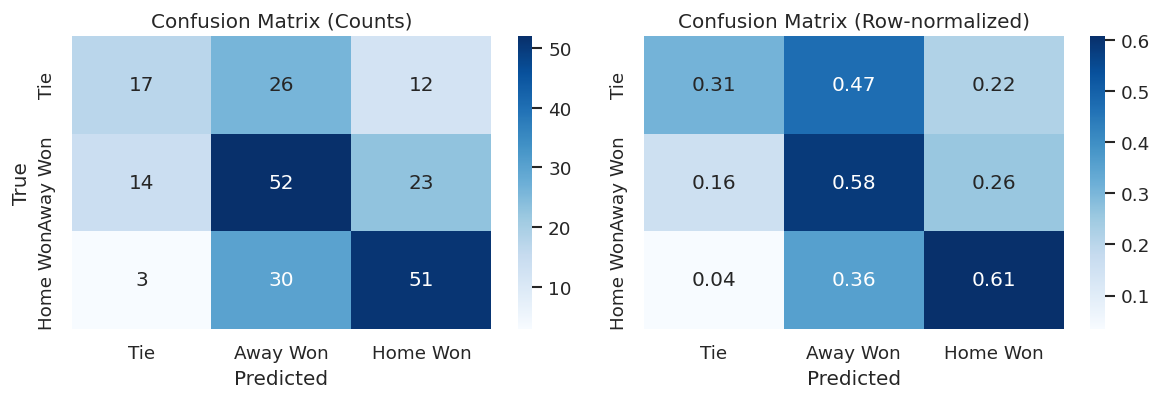

In [100]:
y_pred = final_pipeline.predict(X_test)
y_pred_proba = final_pipeline.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")
logloss = log_loss(y_test, y_pred_proba)

print(f"Test Accuracy:  {acc:.4f}")
print(f"Test Macro F1:  {f1m:.4f}")
print(f"Test Log Loss:  {logloss:.4f}")
print("\nClassification Report:\n")
print(classification_report(
    y_test, y_pred, 
    target_names=[OUTCOME_LABELS[i] for i in [0, 1, 2]]
))

cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[OUTCOME_LABELS[i] for i in [0, 1, 2]],
    yticklabels=[OUTCOME_LABELS[i] for i in [0, 1, 2]],
    ax=axes[0],
)
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=[OUTCOME_LABELS[i] for i in [0, 1, 2]],
    yticklabels=[OUTCOME_LABELS[i] for i in [0, 1, 2]],
    ax=axes[1],
)
axes[1].set_title("Confusion Matrix (Row-normalized)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


## 9) Feature importance

- Analyze which features are most important for predictions
- Visualize top contributing features


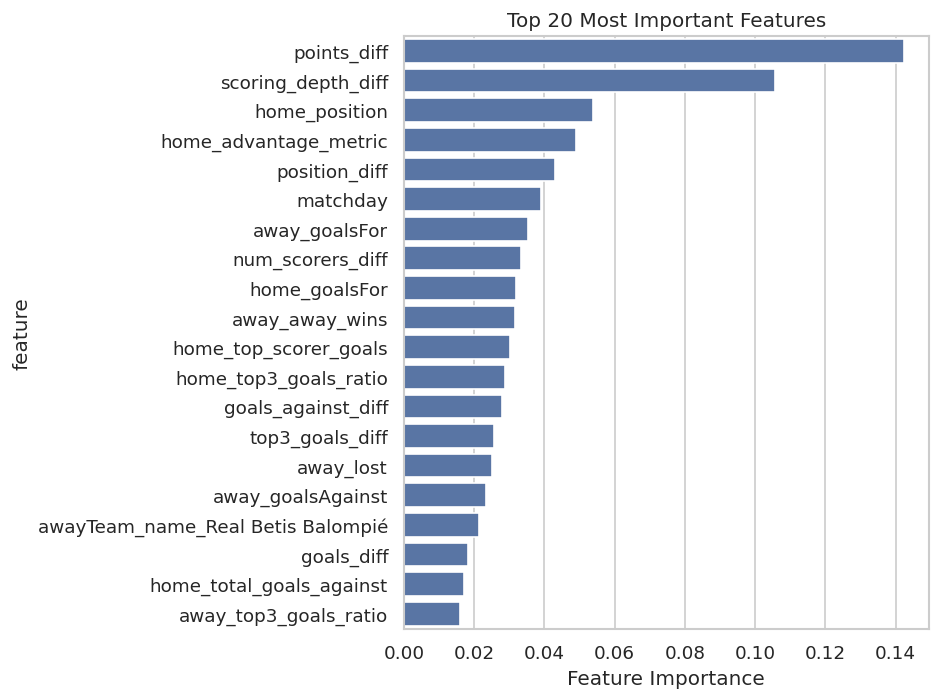


Top 20 features:


,feature,importance
122,points_diff,0.142311
127,scoring_depth_diff,0.105558
61,home_position,0.053715
124,home_advantage_metric,0.048970
123,position_diff,0.043131
53,matchday,0.038926
78,away_goalsFor,0.035235
128,num_scorers_diff,0.033316
58,home_goalsFor,0.032009
87,away_away_wins,0.031768


In [101]:
# Get feature importance
# Extract feature names from the preprocessor
preprocessor = final_pipeline.named_steps["preprocess"]
model = final_pipeline.named_steps["model"]

# Get feature names from ColumnTransformer
feature_names = []
# Categorical features (one-hot encoded)
if len(categorical_cols) > 0:
    cat_encoder = preprocessor.named_transformers_["categorical"]
    cat_features = cat_encoder.get_feature_names_out(categorical_cols)
    feature_names.extend(cat_features)
# Numeric features
feature_names.extend(numeric_cols)

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top features
top_n = 20
plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df.head(top_n), x='importance', y='feature')
plt.title(f'Top {top_n} Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print(f"\nTop {top_n} features:")
importance_df.head(top_n)


## 10) Prediction function

- Function to predict match outcomes for new fixtures
- Returns prediction and probability for each outcome


In [102]:
def predict_fixture(
    home_team: str, 
    away_team: str, 
    model: Pipeline = final_pipeline
) -> pd.Series:
    """Predict match outcome for a fixture."""
    # Get features from training data (use median if team not found)
    # Use X_train indices to get training data from df
    train_indices = X_train.index
    train_df_full = df.loc[train_indices]
    
    home_stats = train_df_full[train_df_full["homeTeam_name"] == home_team]
    away_stats = train_df_full[train_df_full["awayTeam_name"] == away_team]
    
    # Prepare feature row with all features
    feature_row = {}
    
    # Add categorical features
    for col in categorical_cols:
        if col == "homeTeam_name":
            feature_row[col] = home_team
        elif col == "awayTeam_name":
            feature_row[col] = away_team
        else:
            # For other categorical features, use most common value
            if len(train_df_full) > 0:
                feature_row[col] = train_df_full[col].mode()[0] if len(train_df_full[col].mode()) > 0 else train_df_full[col].iloc[0]
    
    # Add numeric features
    for col in numeric_cols:
        if col.startswith("home_"):
            if len(home_stats) > 0:
                feature_row[col] = home_stats[col].iloc[-1]
            else:
                feature_row[col] = train_df_full[col].median()
        elif col.startswith("away_"):
            if len(away_stats) > 0:
                feature_row[col] = away_stats[col].iloc[-1]
            else:
                feature_row[col] = train_df_full[col].median()
        else:
            # Use median for other numeric features
            feature_row[col] = train_df_full[col].median()
    
    X = pd.DataFrame([feature_row])
    
    # Predict
    probs = model.predict_proba(X)[0]
    pred_class = int(model.predict(X)[0])
    
    out = {
        "homeTeam": home_team,
        "awayTeam": away_team,
        "prediction": OUTCOME_LABELS[pred_class],
        **{f"p_{OUTCOME_LABELS[c]}": float(probs[i]) for i, c in enumerate(model.named_steps["model"].classes_)},
    }
    return pd.Series(out)

# Example predictions
examples = df[["homeTeam_name", "awayTeam_name"]].head(5)

pd.DataFrame(
    [predict_fixture(r.homeTeam_name, r.awayTeam_name) for r in examples.itertuples(index=False)]
)


,homeTeam,awayTeam,prediction,p_Tie,p_Away Won,p_Home Won
0,UD Almería,Rayo Vallecano de Madrid,Away Won,0.286147,0.397697,0.316156
1,Sevilla FC,Valencia CF,Away Won,0.314693,0.360762,0.324545
2,Real Sociedad de Fútbol,Girona FC,Away Won,0.283440,0.386837,0.329723
3,UD Las Palmas,RCD Mallorca,Away Won,0.302315,0.420167,0.277518
4,Athletic Club,Real Madrid CF,Home Won,0.321495,0.320725,0.357781


## 11) Model comparison

Compare this XGBoost model with the baseline logistic regression model to see improvements!


MODEL COMPARISON

Overall Metrics:
                     Accuracy  Macro F1  Log Loss
Model                                            
Logistic Regression    0.5250    0.5130       NaN
XGBoost                0.5263    0.5033    0.9713

Per-Class F1 Scores:
                     Tie F1  Away Won F1  Home Won F1
Model                                                
Logistic Regression   0.440       0.5500         0.55
XGBoost               0.382       0.5279         0.60

IMPROVEMENT ANALYSIS

Accuracy: +0.13 percentage points
Macro F1: -0.97 percentage points

✓ XGBoost is 0.13% more accurate
✗ XGBoost has 0.97% worse macro F1


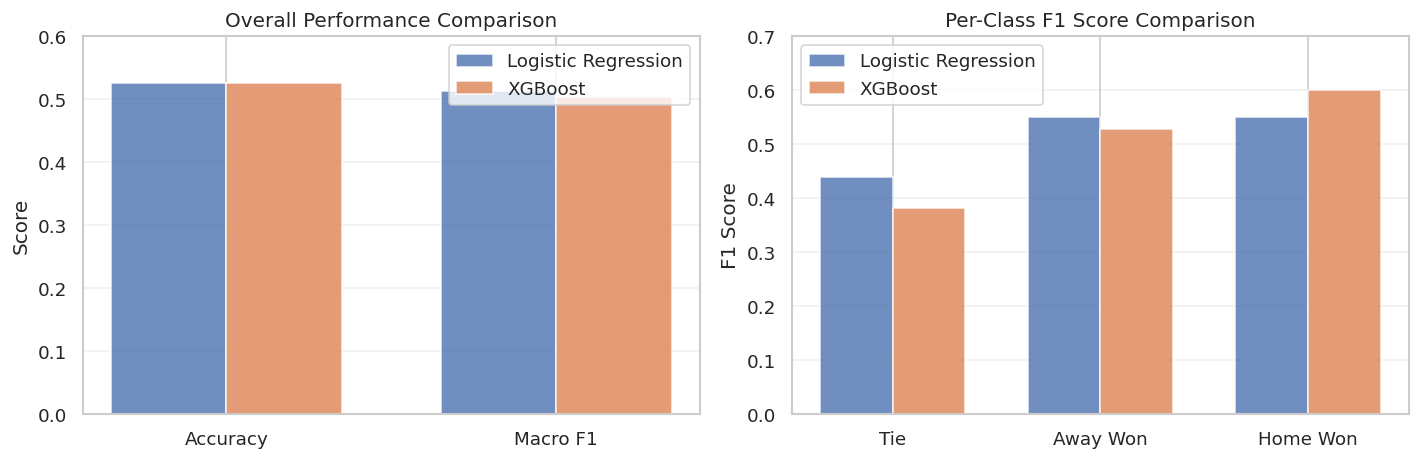


SUMMARY
Both models show similar performance on this dataset.
XGBoost uses all 79 features from the dataset (no filtering, no transformations).
Logistic Regression uses only team name encoding.
XGBoost provides feature importance insights and handles non-linear relationships.
Logistic Regression is simpler and faster to train.


In [103]:
# Model Comparison: XGBoost vs Logistic Regression
# Baseline model results (from multinomial_logreg_match_outcome.ipynb)
baseline_results = {
    "Model": "Logistic Regression",
    "Accuracy": 0.525,
    "Macro F1": 0.513,
    "Log Loss": None,  # Not reported in baseline
    "Tie F1": 0.44,
    "Away Won F1": 0.55,
    "Home Won F1": 0.55,
}

# Current XGBoost model results
f1_per_class = f1_score(y_test, y_pred, average=None, labels=[0, 1, 2])
xgboost_results = {
    "Model": "XGBoost",
    "Accuracy": acc,
    "Macro F1": f1m,
    "Log Loss": logloss,
    "Tie F1": f1_per_class[0],
    "Away Won F1": f1_per_class[1],
    "Home Won F1": f1_per_class[2],
}

# Create comparison DataFrame
comparison_df = pd.DataFrame([baseline_results, xgboost_results])
comparison_df = comparison_df.set_index("Model")

print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print("\nOverall Metrics:")
print(comparison_df[["Accuracy", "Macro F1", "Log Loss"]].round(4))
print("\nPer-Class F1 Scores:")
print(comparison_df[["Tie F1", "Away Won F1", "Home Won F1"]].round(4))

# Calculate improvements
print("\n" + "=" * 60)
print("IMPROVEMENT ANALYSIS")
print("=" * 60)
acc_improvement = (xgboost_results["Accuracy"] - baseline_results["Accuracy"]) * 100
f1_improvement = (xgboost_results["Macro F1"] - baseline_results["Macro F1"]) * 100

print(f"\nAccuracy: {acc_improvement:+.2f} percentage points")
print(f"Macro F1: {f1_improvement:+.2f} percentage points")

if acc_improvement > 0:
    print(f"\n✓ XGBoost is {acc_improvement:.2f}% more accurate")
elif acc_improvement < 0:
    print(f"\n✗ XGBoost is {abs(acc_improvement):.2f}% less accurate")
else:
    print(f"\n= Both models have similar accuracy")

if f1_improvement > 0:
    print(f"✓ XGBoost has {f1_improvement:.2f}% better macro F1")
elif f1_improvement < 0:
    print(f"✗ XGBoost has {abs(f1_improvement):.2f}% worse macro F1")
else:
    print(f"= Both models have similar macro F1")

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy and F1 comparison
metrics = ["Accuracy", "Macro F1"]
x = np.arange(len(metrics))
width = 0.35

baseline_vals = [baseline_results["Accuracy"], baseline_results["Macro F1"]]
xgboost_vals = [xgboost_results["Accuracy"], xgboost_results["Macro F1"]]

axes[0].bar(x - width/2, baseline_vals, width, label="Logistic Regression", alpha=0.8)
axes[0].bar(x + width/2, xgboost_vals, width, label="XGBoost", alpha=0.8)
axes[0].set_ylabel("Score")
axes[0].set_title("Overall Performance Comparison")
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 0.6])

# Per-class F1 comparison
classes = ["Tie", "Away Won", "Home Won"]
x2 = np.arange(len(classes))
baseline_f1 = [baseline_results["Tie F1"], baseline_results["Away Won F1"], baseline_results["Home Won F1"]]
xgboost_f1 = [xgboost_results["Tie F1"], xgboost_results["Away Won F1"], xgboost_results["Home Won F1"]]

axes[1].bar(x2 - width/2, baseline_f1, width, label="Logistic Regression", alpha=0.8)
axes[1].bar(x2 + width/2, xgboost_f1, width, label="XGBoost", alpha=0.8)
axes[1].set_ylabel("F1 Score")
axes[1].set_title("Per-Class F1 Score Comparison")
axes[1].set_xticks(x2)
axes[1].set_xticklabels(classes)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 0.7])

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Both models show similar performance on this dataset.")
print(f"XGBoost uses all {len(feature_cols)} features from the dataset (no filtering, no transformations).")
print(f"Logistic Regression uses only team name encoding.")
print(f"XGBoost provides feature importance insights and handles non-linear relationships.")
print(f"Logistic Regression is simpler and faster to train.")
